# __Forage de données__

### __Importation des bibliothéques__

In [57]:
import sklearn
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [58]:
data=pd.read_csv("/kaggle/input/data-tp3/TP3_data.csv", index_col = 0)

In [59]:
data.head()

,Attribut1,Attribut2,Attribut3,Attribut4,Classe
0,-7.662408,-5.851448,5.958728,7.846234,5.0
1,-5.287012,-10.373240,9.883442,8.947388,5.0
2,-8.048882,-5.600485,2.384850,-9.083051,8.0
3,-15.243415,-5.925116,-0.348595,-6.381597,8.0
4,3.693635,-7.545713,-0.465179,-1.017517,16.0


In [60]:
data.shape

(10000, 5)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Attribut1  10000 non-null  float64
 1   Attribut2  10000 non-null  float64
 2   Attribut3  10000 non-null  float64
 3   Attribut4  10000 non-null  float64
 4   Classe     10000 non-null  float64
dtypes: float64(5)
memory usage: 468.8 KB


## __1. Implémentation de fonctions__
Je commence par séparer mes targets variables et mes features et je les stocke respectivement dans les variables y et X

In [62]:
X=data[['Attribut1','Attribut2','Attribut3','Attribut4']]
y=data['Classe']

### __Prétraitement__ : 
je standardise les données pour commencer la manipulation des données

In [63]:
X = StandardScaler().fit_transform(X)

### __(a) une fonction model_score(X,y,class_model,params)__

In [64]:
def model_score(X,y,class_model,params):
    class_model.set_params(**params)
    scores = cross_val_score(class_model, X, y, cv=5)
    return scores.mean()

In [65]:
params = {'n_neighbors': 10, 'p': 5}
class_model = KNeighborsClassifier()

In [66]:
accuracy=model_score(X,y,class_model,params)

In [67]:
print('accuracy =',accuracy)

accuracy = 0.7133


### __(b) une fonction bruteforce_optimisation(class_model,grille_param,X,y)__

In [68]:
def bruteforce_optimisation(class_model,grille_param,X,y):
    max_score = 0
    max_params = {}
    for params in itertools.product(*grille_param.values()):
        params_dict = dict(zip(grille_param.keys(), params))
        score = model_score(X,y,class_model,params_dict)
        if score > max_score:
            max_score = score
            max_params = params_dict
    return max_params

In [69]:
grille_param={'n_neighbors': range(1,11), 'p': range(1,6)}


In [70]:
max_params=bruteforce_optimisation(class_model,grille_param,X,y)

In [71]:
print('max_params =', max_params)

max_params = {'n_neighbors': 9, 'p': 2}


### __(c) une fonction randomize_optimisation(class_model,grille_param,X,y,sample_percent)__


In [72]:
def randomize_optimisation(class_model, grille_param, X, y, sample_percent):
    max_score = 0
    max_params = None
    all_params = list(product(*grille_param.values()))
    sample_size = int(len(all_params) * sample_percent / 100)
    sampled_params = random.sample(all_params, sample_size)
    for params in sampled_params:
        params = dict(zip(grille_param.keys(), params))
        score = model_score(X, y, class_model, params)
        if score > max_score:
            max_score = score
            max_params = params
    return max_params

In [73]:
max_params = randomize_optimisation(class_model,grille_param,X,y,sample_percent = 30)

In [74]:
print('max_params = ', max_params)

max_params =  {'n_neighbors': 10, 'p': 4}


### __(d) une fonction halving_optimisation(class_model,grille_param,X,y,n_splitting)__

In [75]:
from sklearn.model_selection import cross_val_score

def halving_optimisation(class_model, grille_param, X, y, n_splitting):
    param_list = [dict(zip(grille_param.keys(), v)) for v in product(*grille_param.values())]
    n_samples = len(X)
    for i in range(n_splitting):
        scores = []
        for params in param_list:
            model = class_model(**params)
            score = cross_val_score(model, X[:int(n_samples*(i+1)/n_splitting)], y[:int(n_samples*(i+1)/n_splitting)], cv=5).mean()
            scores.append(score)
        best_params_index = max(1,int(len(param_list)*(n_splitting-i-1)/n_splitting))
        param_list = sorted(param_list,key=lambda x: scores[param_list.index(x)],reverse=True)[:best_params_index]
    return param_list[0]

In [76]:
max_params = halving_optimisation(KNeighborsClassifier, grille_param, X, y, n_splitting = 5)

In [77]:
print('max_params =', max_params )

max_params = {'n_neighbors': 10, 'p': 2}


### __(e) une fonction bayesian_optimisation(class_model,grille_param,X,y,s_size,n_iter)__

In [78]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from itertools import product
import numpy as np

def bayesian_optimisation(class_model, grille_param, X, y, s_size, n_iter):
    param_space = list(product(*grille_param.values()))
    E = np.random.choice(len(param_space), size=s_size, replace=False)
    X_sample = np.array([param_space[i] for i in E])
    y_sample = np.array([model_score(X, y, class_model, dict(zip(grille_param.keys(), params))) for params in X_sample])
    gp = GaussianProcessRegressor()
    gp.fit(X_sample, y_sample)
    for i in range(n_iter):
        means, stds = gp.predict(param_space, return_std=True)
        max_pred_mean = means.max()
        new_params = np.random.choice(len(param_space), size=s_size, replace=False)
        new_means, new_stds = gp.predict([param_space[i] for i in new_params], return_std=True)
        probs = norm.cdf((new_means - max_pred_mean) / (new_stds + 1e-6))
        max_param_index = new_params[probs.argmax()]
        max_param = param_space[max_param_index]
        E = np.append(E, max_param_index)
        X_sample = np.append(X_sample, [max_param], axis=0)
        y_sample = np.append(y_sample, model_score(X, y, class_model, dict(zip(grille_param.keys(), max_param))))
        gp.fit(X_sample, y_sample)
    return dict(zip(grille_param.keys(), X_sample[y_sample.argmax()]))

In [79]:
class_model = KNeighborsClassifier()
grille_param = {'n_neighbors': range(1, 21), 'p': range(1, 11)}

In [80]:
result = bayesian_optimisation(class_model, grille_param, X, y, s_size=5, n_iter=100)

In [81]:
print(result)

{'n_neighbors': 19, 'p': 4}


## __2. Comparaison de fonctions :__

### __(a) Proposez un partitionnement des données en données d’entraînement et données de test.__

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

### __(b) Présentez un graphique des scores d’entraînement, et un graphique des scores de test, pour tous les paramétrages de l’espace de recherche, sous forme de heatmap.__

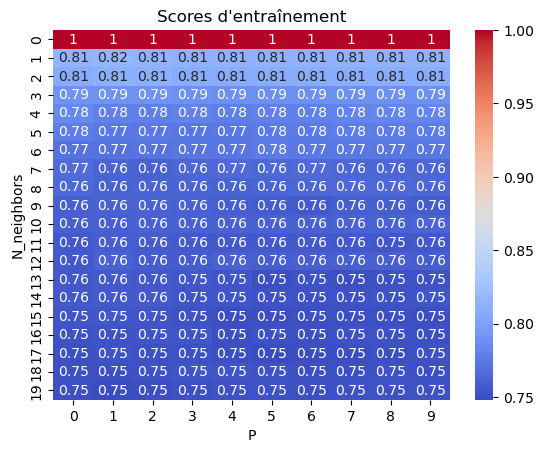

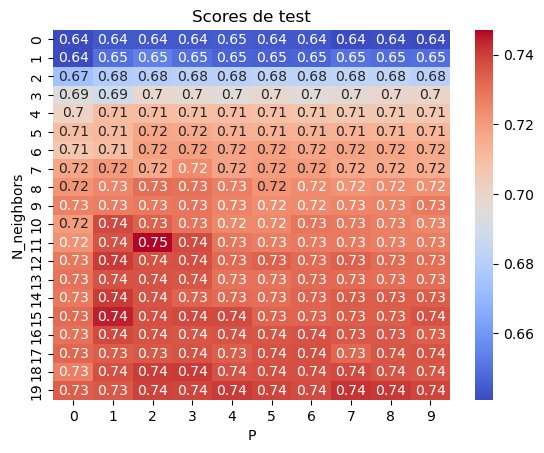

In [83]:
parametres = {'n_neighbors': range(1,21), 'p':range(1,11)}

scores_train = np.zeros((len(parametres['n_neighbors']),len(parametres['p'])))
scores_test = np.zeros((len(parametres['n_neighbors']),len(parametres['p'])))
for i,n_neighbors in enumerate(parametres['n_neighbors']):
    for j,p in enumerate(parametres['p']):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors,p=p)
        knn.fit(X_train,y_train)
        scores_train[i,j] = knn.score(X_train,y_train)
        scores_test[i,j] = knn.score(X_test,y_test)

sns.heatmap(scores_train,cmap='coolwarm',annot=True)
plt.title('Scores d\'entraînement')
plt.xlabel('P')
plt.ylabel('N_neighbors')
plt.show()

sns.heatmap(scores_test,cmap='coolwarm',annot=True)
plt.title('Scores de test')
plt.xlabel('P')
plt.ylabel('N_neighbors')
plt.show()

### __(c) Réglages des hyperparamètres avec les fonctions__

#### __Avec la fonction bruteforce_optimisation__

In [84]:
grille_param={'n_neighbors': range(1,21), 'p': range(1,11)}

In [85]:
param = bruteforce_optimisation(KNeighborsClassifier(),grille_param, X, y)

In [86]:
print(param)

{'n_neighbors': 19, 'p': 4}


#### __Avec la fonction randomize_optimisation__

In [87]:
param1 = randomize_optimisation(KNeighborsClassifier(), grille_param, X, y, sample_percent = 30)

In [88]:
print(param1)

{'n_neighbors': 19, 'p': 5}


#### __Avec la fonction halving_optimisation__

In [89]:
param2 = halving_optimisation(KNeighborsClassifier, grille_param, X, y, n_splitting = 5)

In [90]:
print(param2)

{'n_neighbors': 19, 'p': 7}


#### __Avec la fonction bayesian_optimisation__

In [91]:
param3 = bayesian_optimisation(KNeighborsClassifier(),grille_param,X,y,s_size = 5,n_iter=100)

In [92]:
print(param3)

{'n_neighbors': 19, 'p': 5}


#### __Utilisation de GridSearchCV avec scoring = "accuracy"__

In [93]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KNeighborsClassifier(), grille_param, scoring = "accuracy", cv = 5)
grid.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21), 'p': range(1, 11)},
             scoring='accuracy')

In [94]:
grid.best_params_

{'n_neighbors': 19, 'p': 4}

#### __Utilisation de RandomizedSearchCV avec scoring = 'accuracy' et n_iter = 60__

In [95]:
from sklearn.model_selection import RandomizedSearchCV
grid2 = RandomizedSearchCV(KNeighborsClassifier(), grille_param, scoring = "accuracy", cv = 5, n_iter = 30)
grid2.fit(X,y)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=30,
                   param_distributions={'n_neighbors': range(1, 21),
                                        'p': range(1, 11)},
                   scoring='accuracy')

In [96]:
grid2.best_params_

{'p': 4, 'n_neighbors': 19}

#### __Utilisation de HalvingGridSearchCV avec factor = 5 et scoring = 'accuracy'__

In [97]:
from sklearn.model_selection import HalvingGridSearchCV
grid3 = HalvingGridSearchCV(KNeighborsClassifier(), grille_param, scoring = "accuracy", cv = 5, factor = 5)
grid3.fit(X,y)

ImportError: cannot import name 'HalvingGridSearchCV' from 'sklearn.model_selection' (/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/__init__.py)

In [ ]:
grid3.best_params_

#### __Utilisation de gp_minimize__

In [98]:
from skopt import gp_minimize

In [99]:
def objective(params):
    n_neighbors, p = params
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
    score = cross_val_score(clf, X, y, cv=5).mean()
    return 1 - score

In [100]:
from skopt.space import Real, Integer
#Définissons l'espace des hyperparamètres
space = [Integer(1, 20, name='n_neighbors'),
         Integer(1, 10, name='p')]

In [101]:
result = gp_minimize(objective, space, n_calls=100, random_state=0)

In [102]:
print("Best parameters:", result.x)

Best parameters: [19, 4]
